In [1]:
import os

import pandas as pd
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing import image
import cv2
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%cd ..

C:\Users\Govert\Documents\VG_covers


In [3]:
# create function to load in images

%config InlineBackend.figure_format= 'retina' 

def load_image_from_path(image_path, target_size = None, color_mode = 'rgb'):
    pil_image = image.load_img(image_path, target_size=target_size,
                            color_mode=color_mode)
    return image.img_to_array(pil_image)

For HSV in cv2, Hue range is [0,360], Saturation range is [0,1] and Value range is [0,255]. 
Different softwares use different scales.

In [4]:
# define function to find the median and standard deviation of hsv values


def color_statistics(image_path):
    im = load_image_from_path(image_path, color_mode='rgb')
    color_image_hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
    median_h, median_s, median_v = np.median(color_image_hsv, axis=(0,1))
    std_h, std_s, std_v = np.std(color_image_hsv, axis=(0,1))
    return median_h, median_s, median_v, std_h, std_s, std_v

In [5]:
# folder with all images
im_dir = 'data/covers/'
paths = os.listdir(im_dir)

In [6]:
median_h = []
median_s = []
median_v = []
std_h = []
std_s = []
std_v = []

for p in paths:
    res = color_statistics(im_dir + p)
    median_h.append(res[0])
    median_s.append(res[1])
    median_v.append(res[2])
    std_h.append(res[3])
    std_s.append(res[4])
    std_v.append(res[5])

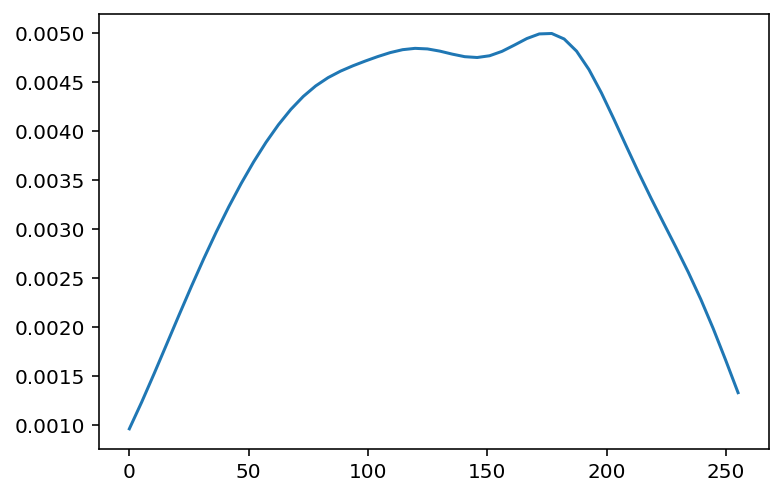

In [7]:
density = gaussian_kde(median_v)
xs = np.linspace(0,255)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.show()

In [8]:
face_df = pd.DataFrame(zip(paths, median_h, median_s, median_v, std_h, std_s,std_v))
face_df.columns = ['path', 'median_h', 'median_s','median_v', 'std_h','std_s','std_v']

face_df['id'] = face_df.path.apply(lambda x: x.split('.')[0])
face_df['id'] = face_df.id.astype('int64')

games_df = pd.read_csv('data/games.csv')
results = face_df.merge(games_df, how='left', on='id')
results['binary'] = results.rating > 3

In [9]:
results.to_csv('output/features/color_results.csv')

In [10]:
plot_df = results[['median_v','std_v','binary']]
plot_df.columns = ['median_v', 'std_v', 'age label']
plot_df.loc[:,'age label'] = plot_df.loc[:,'age label'].replace(True, 'Over 16')
plot_df.loc[:,'age label'] = plot_df.loc[:,'age label'].replace(False, 'Under 16')

C:\Users\Govert\.conda\envs\dm_project\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


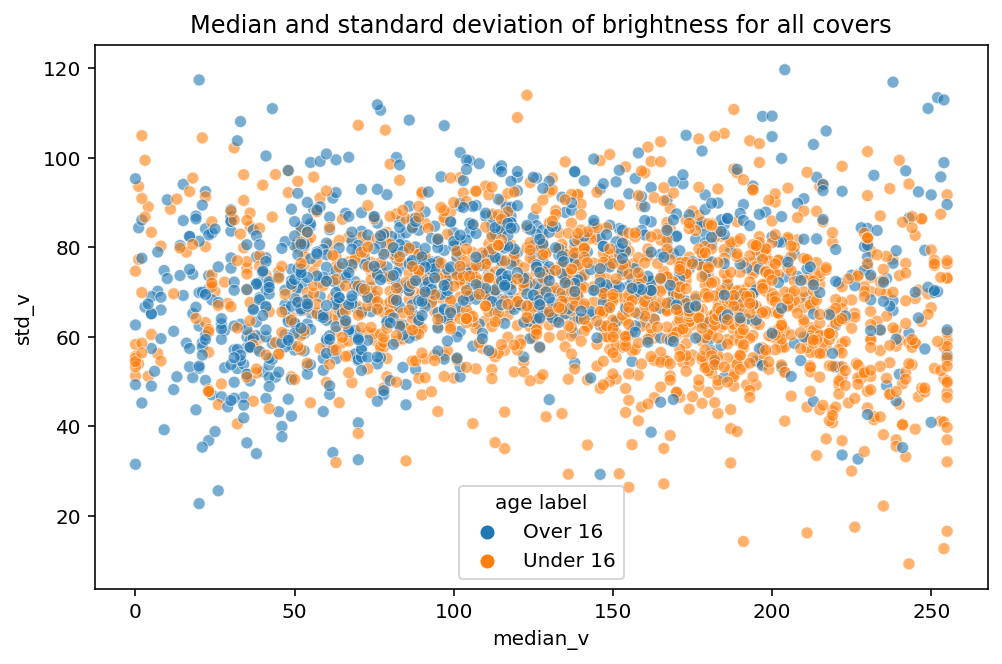

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
_ = sns.scatterplot(x = 'median_v', y = 'std_v', hue = 'age label', data = plot_df, alpha = 0.6, ax = ax)
_ = ax.set_title('Median and standard deviation of brightness for all covers')

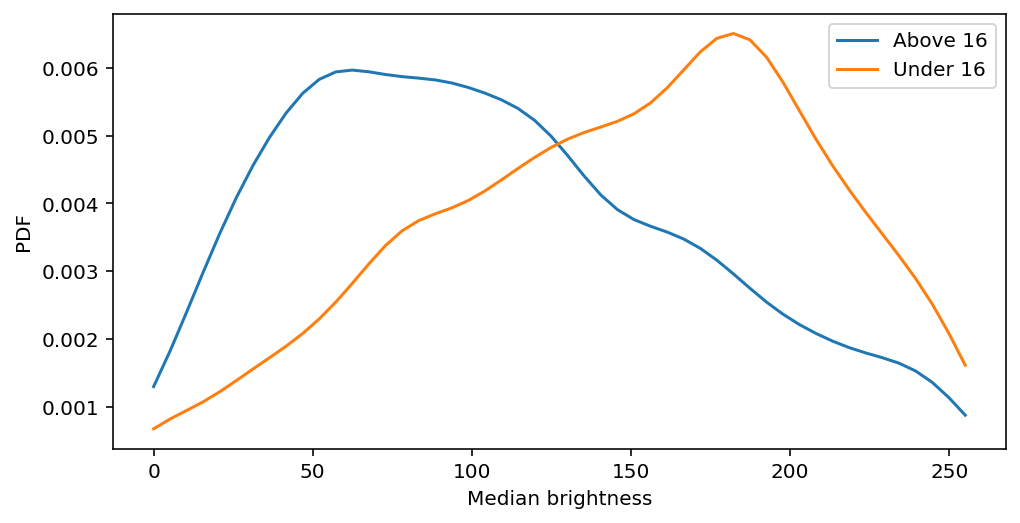

In [12]:
density = gaussian_kde(results[results.binary == True].median_v)
density2 = gaussian_kde(results[results.binary == False].median_v)

xs = np.linspace(0,255)

density.covariance_factor = lambda : .2
density._compute_covariance()

density2.covariance_factor = lambda : .2
density2._compute_covariance()

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(xs,density(xs), label = 'Above 16')
ax.plot(xs,density2(xs), label = 'Under 16')

ax.set_ylabel('PDF')
ax.set_xlabel('Median brightness')
ax.legend()

plt.show()

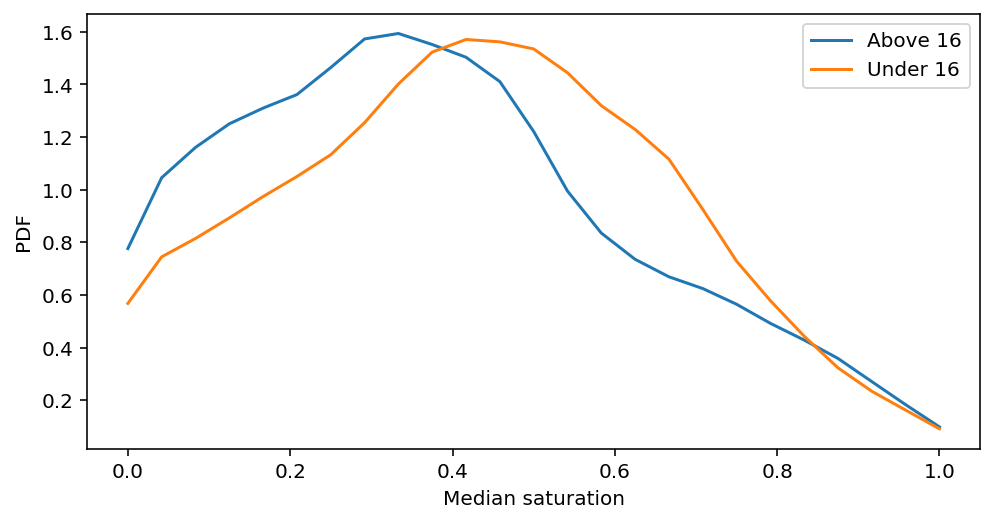

In [13]:
density = gaussian_kde(results[results.binary == True].median_s)
density2 = gaussian_kde(results[results.binary == False].median_s)

xs = np.linspace(0,1,25)

density.covariance_factor = lambda : .2
density._compute_covariance()

density2.covariance_factor = lambda : .2
density2._compute_covariance()

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(xs,density(xs), label = 'Above 16')
ax.plot(xs,density2(xs), label = 'Under 16')

ax.set_ylabel('PDF')
ax.set_xlabel('Median saturation')
ax.legend()

plt.show()

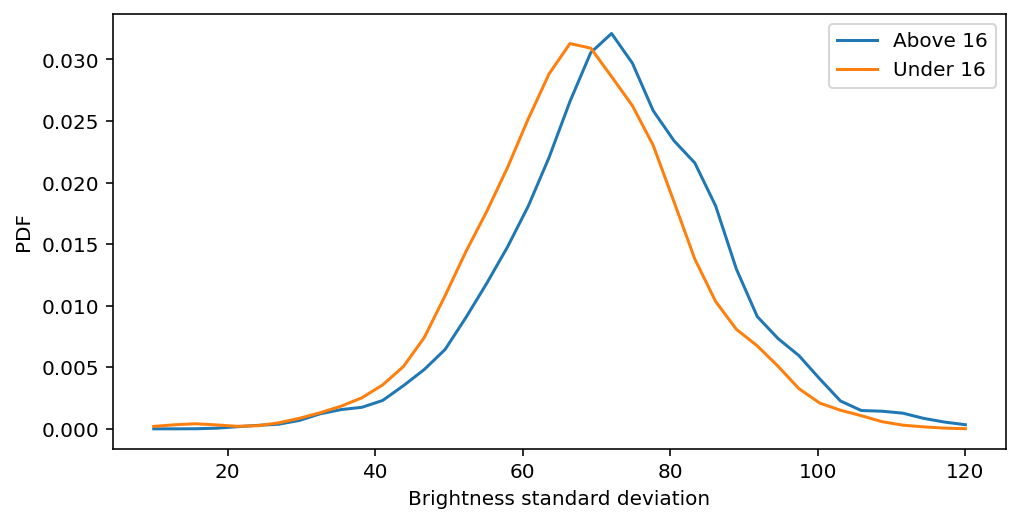

In [14]:
density = gaussian_kde(results[results.binary == True].std_v)
density2 = gaussian_kde(results[results.binary == False].std_v)

xs = np.linspace(10,120,40)

density.covariance_factor = lambda : .2
density._compute_covariance()

density2.covariance_factor = lambda : .2
density2._compute_covariance()

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(xs,density(xs), label = 'Above 16')
ax.plot(xs,density2(xs), label = 'Under 16')

ax.set_ylabel('PDF')
ax.set_xlabel('Brightness standard deviation')
ax.legend()

plt.show()

In [15]:
color_statistics('cs_go.jpg')

(221.53847, 0.5, 20.0, 17.093437, 0.2731214, 53.01795)

In [16]:
color_statistics('marioparty.jpg')

(109.72973, 0.61087865, 177.0, 100.82442, 0.28380677, 63.79652)